# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [8]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler1=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
        if not scheduler:
            continue
        
        if epoch % 2 == 0:
            continue

        scheduler.step()

        if not scheduler1:
            continue

        scheduler1.step(ave_loss)
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    correct_samples = 0
    total_samples = 0
    
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)    
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
         
    accuracy = float(correct_samples) / total_samples

    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.816367, Train accuracy: 0.421083, Val accuracy: 0.553751
Average loss: 1.451959, Train accuracy: 0.589138, Val accuracy: 0.609856
Average loss: 1.378679, Train accuracy: 0.621592, Val accuracy: 0.631220


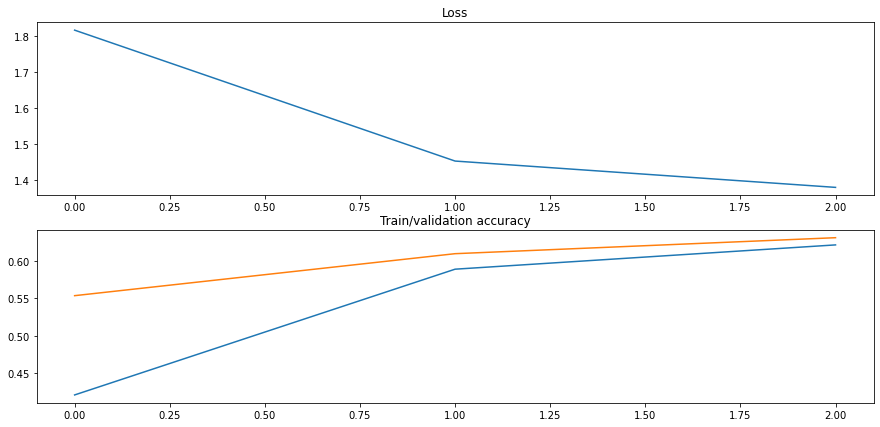

In [9]:
# Visualise results
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [10]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
       Flattener(),
       nn.Linear(3*32*32, 100),
       nn.ReLU(inplace=True),
       nn.Linear(100, 100),
       nn.ReLU(inplace=True),
       nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.159821, Train accuracy: 0.214500, Val accuracy: 0.244284
Average loss: 1.996601, Train accuracy: 0.277190, Val accuracy: 0.309672
Average loss: 1.812835, Train accuracy: 0.368938, Val accuracy: 0.384888
Average loss: 1.708094, Train accuracy: 0.421186, Val accuracy: 0.427206
Average loss: 1.676134, Train accuracy: 0.437447, Val accuracy: 0.433964


Добавьте слой с Batch Normalization

In [13]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10)
          )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.922029, Train accuracy: 0.378255, Val accuracy: 0.539554
Average loss: 1.509428, Train accuracy: 0.587056, Val accuracy: 0.646372
Average loss: 1.332893, Train accuracy: 0.647698, Val accuracy: 0.683366
Average loss: 1.233902, Train accuracy: 0.677507, Val accuracy: 0.705276
Average loss: 1.175224, Train accuracy: 0.696533, Val accuracy: 0.685892


Добавьте уменьшение скорости обучения по ходу тренировки.

In [14]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, 100),
                nn.BatchNorm1d(100),
                nn.ReLU(inplace=True),
                nn.Linear(100, 100),
                nn.BatchNorm1d(100),
                nn.ReLU(inplace=True),
                nn.Linear(100, 10)    
         )

nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 1.749475, Train accuracy: 0.463383, Val accuracy: 0.433076
Average loss: 1.605037, Train accuracy: 0.551769, Val accuracy: 0.506041
Average loss: 1.592753, Train accuracy: 0.581408, Val accuracy: 0.589994
Average loss: 1.611730, Train accuracy: 0.573150, Val accuracy: 0.589448
Average loss: 1.578612, Train accuracy: 0.596321, Val accuracy: 0.579346


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [11]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    subset_sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, sampler=subset_sampler)

    samples_amount = len(loader)
    predictions = np.empty(samples_amount, dtype=np.int)
    ground_truth = np.empty(samples_amount, dtype=np.int)

    for i_step, (x, y) in enumerate(loader):
        prediction = model(x) 
        index = torch.argmax(prediction, 1)
        predictions[i_step] = index
        ground_truth[i_step] = y   
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

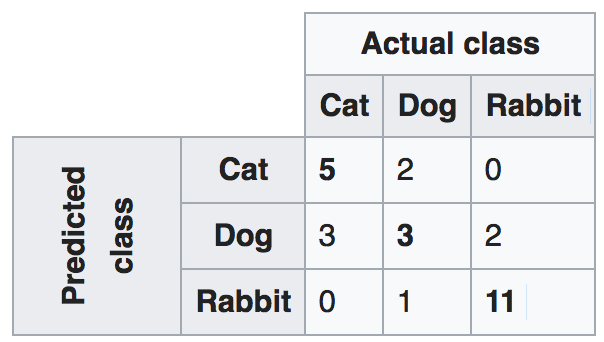

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

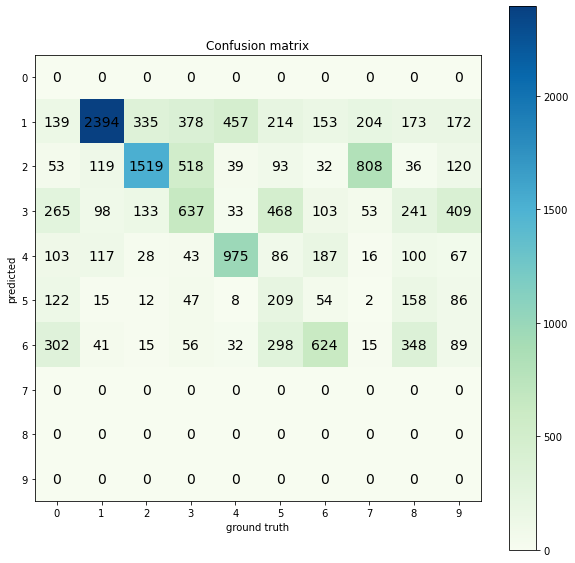

In [12]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix

    for i, j in zip(predictions, gt):
            confusion_matrix[i, j] += 1

    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспьзоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

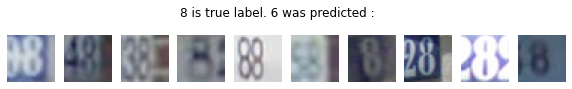

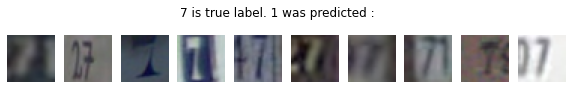

In [14]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
  
    index = (predictions==predicted_class) & (groud_truth==gt_class)
    title = str(gt_class) + " is true label. " + str(predicted_class) + " was predicted :" 
    visualize_images(val_indices[index], data, title)


visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images) 


# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [15]:
import random

Learning rate 0.022677666890794635, 
Learning rater annealing 0.9805427695025538, 
Regularization strength 0.003847666554752814, 
Batch size 60
Average loss: 2.022309, Train accuracy: 0.281678, Val accuracy: 0.287898
Average loss: 2.024672, Train accuracy: 0.276081, Val accuracy: 0.274862
Average loss: 2.053000, Train accuracy: 0.264512, Val accuracy: 0.207221
Average loss: 2.029617, Train accuracy: 0.275893, Val accuracy: 0.286670
Average loss: 2.045315, Train accuracy: 0.265587, Val accuracy: 0.271654
Average loss: 2.047500, Train accuracy: 0.265314, Val accuracy: 0.227356
Average loss: 2.088151, Train accuracy: 0.245487, Val accuracy: 0.261962
Average loss: 2.017799, Train accuracy: 0.278129, Val accuracy: 0.267627
Average loss: 2.006756, Train accuracy: 0.285244, Val accuracy: 0.249061
Average loss: 2.087350, Train accuracy: 0.243832, Val accuracy: 0.241007
Learning rate 0.014963804511518786, 
Learning rater annealing 0.0911687195407308, 
Regularization strength 0.00196228695021223

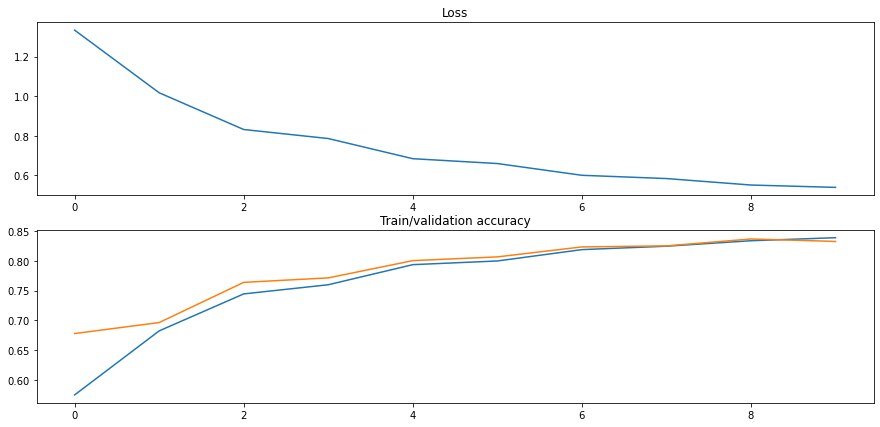

In [52]:
# Experiment here!

num_epochs = 10

best_val_accuracy = 0.

loss_history = []
train_history = []
val_history = []

annotation = """Learning rate {}, 
Learning rater annealing {}, 
Regularization strength {}, 
Batch size {}"""

hyperparameters_presets = []

for i in range(0, 20):
    random.seed()
    learning_rate = pow(10, -1*random.uniform(1 ,4))
    learning_rate_decay = random.uniform(1e-0, 1e-2)
    reg_strength = pow(10, -1*random.uniform(1 ,5))
    batch_size = random.randint(5, 100)

    hyperparameters_presets += [(learning_rate, learning_rate_decay, reg_strength, batch_size)]

for hyperparameters in hyperparameters_presets:
    title = annotation.format(*hyperparameters)
    print(title)

    learning_rate, learning_rate_decay, reg_strength, batch_size = hyperparameters

    # Split data to batch size 
    data_size = data_train.data.shape[0]
    validation_split = .2
    split = int(np.floor(validation_split * data_size))
    indices = list(range(data_size))
    np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

    # Model structure
    nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 200),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(200),
        nn.Linear(200, 150),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(150),
        nn.Linear(150, 10)
        )

    nn_model.type(torch.FloatTensor)


    optimizer = optim.Adam(nn_model.parameters(), learning_rate, weight_decay=reg_strength)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_decay)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler)

    

    accuracy = val_history[-1]

    # Memo best
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_loss_history = loss_history
        best_train_history = train_history
        best_val_history = val_history
        best_hyperparameters = learning_rate, learning_rate_decay, reg_strength, batch_size

# Visualise overall results
conclusion_resume = annotation.format(*best_hyperparameters)
print('\nBest validation accuracy achieved: %f' % best_val_accuracy)
print(conclusion_resume)

# Visualise results
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(best_loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(best_train_history)
plt.plot(best_val_history)




Average loss: 1.364003, Train accuracy: 0.558407, Val accuracy: 0.680158
Average loss: 1.043934, Train accuracy: 0.672798, Val accuracy: 0.697222
Average loss: 0.872483, Train accuracy: 0.728168, Val accuracy: 0.730121
Average loss: 0.830240, Train accuracy: 0.741340, Val accuracy: 0.769163
Average loss: 0.737651, Train accuracy: 0.772191, Val accuracy: 0.796874
Average loss: 0.707417, Train accuracy: 0.781507, Val accuracy: 0.799604
Average loss: 0.642300, Train accuracy: 0.804440, Val accuracy: 0.806157
Average loss: 0.626153, Train accuracy: 0.810002, Val accuracy: 0.812641
Average loss: 0.589401, Train accuracy: 0.822100, Val accuracy: 0.821104
Average loss: 0.575714, Train accuracy: 0.826690, Val accuracy: 0.823971
Average loss: 0.551494, Train accuracy: 0.834437, Val accuracy: 0.830182
Average loss: 0.543794, Train accuracy: 0.836604, Val accuracy: 0.831001
Average loss: 0.528202, Train accuracy: 0.841023, Val accuracy: 0.837622
Average loss: 0.524564, Train accuracy: 0.843327, V

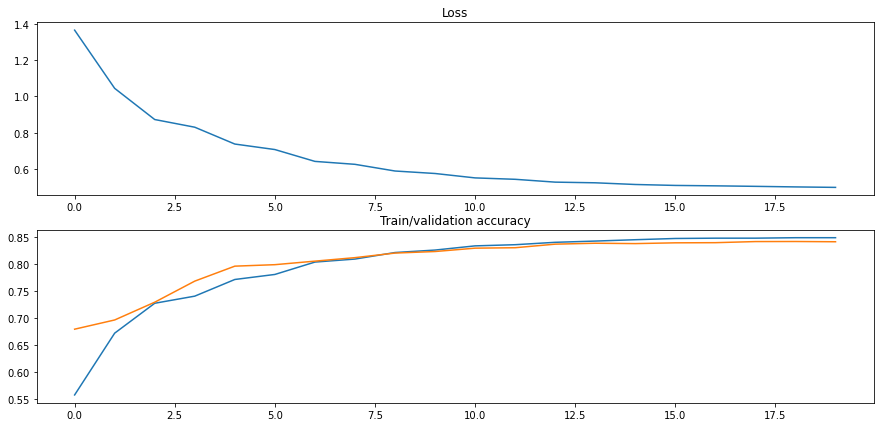

In [118]:
# Best hyperparameters after coarse probing
# Learning rate 0.0007785235988284492, 
# Learning rater annealing 0.501212962397781, 
# Regularization strength 0.005194191094802498, 
# Batch size 86

learning_rate =  0.0007425
learning_rate_decay = 0.56
reg_strength = 0.00517
batch_size = 64
num_epochs = 20
 
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(200),
            nn.Linear(200, 150),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(150),
            nn.Linear(150, 10)
            )

nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), learning_rate, weight_decay=reg_strength)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_decay)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.003, threshold=0.001)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler, scheduler1)

# Visualise results
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

In [119]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8223


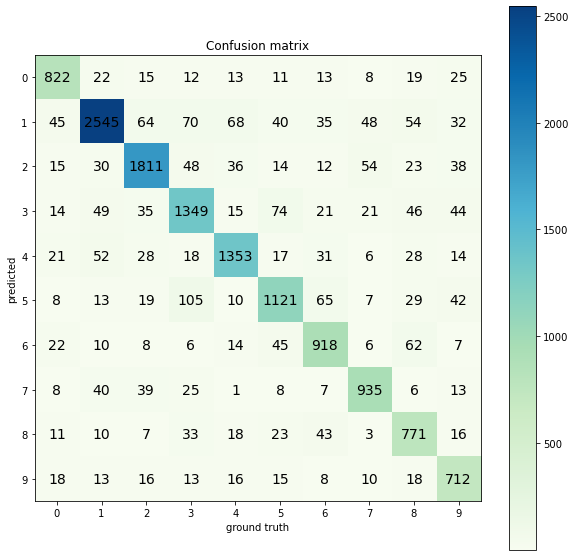

In [120]:
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)